<a href="https://colab.research.google.com/github/phukumuku/cifar10/blob/test/cnn_light_fc2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
csvname = input()+'.csv'

fc2


ツールのインポート

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

ツール（pytorch）のバージョンやGPUの設定確認
- ランタイム -> ランタイムのタイプを変更 -> T4が選択されていればTrueと表示されるはず

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2.3.0+cu121
False


データセットのロードと前処理を実施

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

100%|██████████| 170498071/170498071 [00:03<00:00, 47827716.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


分類用のニューラルネットワークの設定

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.fc1 = nn.Linear(6*32*32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x =F.relu(self.conv1(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def test(self, x):
      return 0


In [6]:
def test(net, testloader):
    net.eval()  # モデルを評価モードに切り替える
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: %d %%' % accuracy)
    return accuracy

分類用ニューラルネットワークのインスタンス化と学習方法の設定

In [7]:
net = Net()
# transfer to gpu
if torch.cuda.is_available():
  net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

学習

In [8]:
import csv

# CSVファイルの準備
with open(csvname, 'w', newline='') as csvfile:
    fieldnames = ['epoch', 'batch', 'loss', 'accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for epoch in range(5):  # loop over the dataset multiple times
        net.train()  # 訓練モードに切り替える
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                writer.writerow({'epoch': epoch + 1, 'batch': i + 1, 'loss': running_loss / 2000, 'accuracy': ''})
                running_loss = 0.0

        # 各エポックの最後に評価を行う
        print(f'Epoch {epoch + 1}')
        accuracy = test(net, testloader)

        # エポックの結果をCSVに書き込む
        writer.writerow({'epoch': epoch + 1, 'batch': '', 'loss': '', 'accuracy': accuracy})

print('Finished Training')

[1,  2000] loss: 2.017
[1,  4000] loss: 1.736
[1,  6000] loss: 1.637
[1,  8000] loss: 1.586
[1, 10000] loss: 1.545
[1, 12000] loss: 1.513
Epoch 1
Accuracy of the network on the 10000 test images: 46 %
[2,  2000] loss: 1.460
[2,  4000] loss: 1.408
[2,  6000] loss: 1.431
[2,  8000] loss: 1.384
[2, 10000] loss: 1.398
[2, 12000] loss: 1.379
Epoch 2
Accuracy of the network on the 10000 test images: 50 %
[3,  2000] loss: 1.284
[3,  4000] loss: 1.301
[3,  6000] loss: 1.289
[3,  8000] loss: 1.283
[3, 10000] loss: 1.292
[3, 12000] loss: 1.293
Epoch 3
Accuracy of the network on the 10000 test images: 52 %
[4,  2000] loss: 1.193
[4,  4000] loss: 1.198
[4,  6000] loss: 1.201
[4,  8000] loss: 1.212
[4, 10000] loss: 1.221
[4, 12000] loss: 1.204
Epoch 4
Accuracy of the network on the 10000 test images: 53 %
[5,  2000] loss: 1.099
[5,  4000] loss: 1.139
[5,  6000] loss: 1.130
[5,  8000] loss: 1.139
[5, 10000] loss: 1.132
[5, 12000] loss: 1.143
Epoch 5
Accuracy of the network on the 10000 test images: 

In [9]:
# クラスごとの精度を計算
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 61 %
Accuracy of automobile : 55 %
Accuracy of  bird : 33 %
Accuracy of   cat : 49 %
Accuracy of  deer : 54 %
Accuracy of   dog : 38 %
Accuracy of  frog : 60 %
Accuracy of horse : 54 %
Accuracy of  ship : 71 %
Accuracy of truck : 58 %


In [10]:
print(f'/content/{csvname}')

/content/fc2.csv


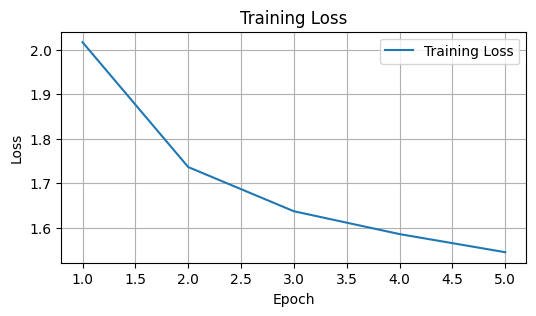

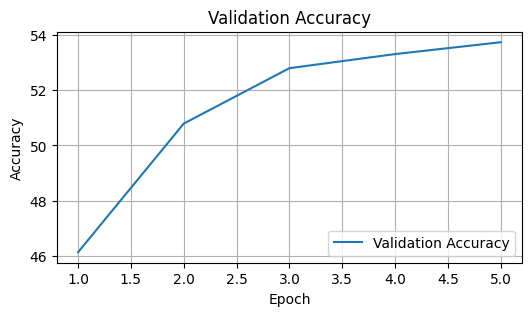

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルからデータを読み込む
data = pd.read_csv(f'/content/{csvname}')

# エポックごとの損失と精度のデータを取得
train_loss = data[data['batch'].notna()]['loss'].values
val_accuracy = data[data['batch'].isna()]['accuracy'].values
epochs = data[data['batch'].isna()]['epoch'].values

# プロット
plt.figure(figsize=(6, 3))
plt.plot(epochs, train_loss[:len(epochs)], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [12]:
from google.colab import files

filename = f'/content/{csvname}'
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>